In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import argparse
from tqdm import tqdm
import sys
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import random

In [2]:
sys.path.append("C:\\Users\\hayas\\proj-regression-general\\git\\code\\regression_seq")
import utils
import main_model
import coach
import optim
import preprocessing
import evaluation
with open('C:\\Users\\hayas\\Dataset_Rapport\\proj-personal-features\\202407\\output\\features_fr.pkl', 'rb') as p:
    features = pickle.load(p)
with open('C:\\Users\\hayas\\Dataset_Rapport\\proj-personal-features\\202402\\output\\cv_fr_topic1_test.pkl', 'rb') as p:
    cv_test = pickle.load(p)

modal = "V"
label = "norm_rapport"
epoch_num = 50

In [3]:
def main(args, train_set_in_test, test_set):
    collator = preprocessing.collator
    dataset = preprocessing.ConversationRelDataModule(train_dataset=train_set_in_test, test_dataset = test_set, batch_size=args.batch_size, \
                                             collator=collator, modal=args.modal, features_dict=features, label=args.label)
    dataset.setup(stage="fit")
    train_dataloader = dataset.train_dataloader()
    dataset.setup(stage="test")
    test_dataloader = dataset.test_dataloader()

    model = main_model.MainModel(args).to(args.device)
    opt = optim.Optim(args.learning_rate, args.max_grad_value, args.weight_decay)
    opt.set_parameters(model.parameters(), args.optimizer)

    coach_model = coach.Coach(train_dataloader, test_dataloader, model, opt, args)
    ret = coach_model.train()
    return ret

In [4]:
log = utils.get_logger()
return_dict = {}

for s in range(10):
    file_name = "exp{}".format(s)
    for test_group_id in cv_test.keys():
        log.info("---------test_id: {}---------".format(test_group_id))
        best_lr = "1e-4"
        
        parser = argparse.ArgumentParser()
        parser.add_argument("--from_begin", type=str, default="True", help="Training from begin.")
        parser.add_argument("--device", type=str, default="cuda:0", help="Computing device.")
        parser.add_argument("--batch_size", default=32, type=int, help="Batch size.")
        parser.add_argument("--drop_rate", type=float, default=0.1, help="Dropout rate.")
        parser.add_argument("--optimizer", type=str, default="adam", choices=["sgd", "rmsprop", "adam"], help="Name of optimizer.")
        parser.add_argument("--learning_rate", type=float, default=1e-5, help="Learning rate.")
        parser.add_argument("--max_grad_value", default=-1, type=float, \
                        help="""If the norm of the gradient vector exceeds this, normalize it to have the norm equal to max_grad_norm""")
        parser.add_argument("--weight_decay", type=float, default=1e-8, help="Weight decay.")
        parser.add_argument("--epochs", default=30, type=int, help="Number of training epochs.")
        parser.add_argument("--rnn", type=str, default="lstm", choices=["lstm", "bi_lstm"], help="rnn model.")
        parser.add_argument("--modal", type=str, default="AL")
        parser.add_argument("--margin", default=1, type=int, help="Margin.")
        parser.add_argument("--intermediate_lstm_uni", default=256, type=int)
        parser.add_argument("--intermediate_mlp_uni", default=256, type=int)
        parser.add_argument("--output_mlp_uni", default=256, type=int)
        parser.add_argument("--intermediate_lstm_mm", default=256, type=int)
        parser.add_argument("--intermediate_mlp_mm", default=256, type=int)
        parser.add_argument("--label", type=str, default="Rapport")

        args = parser.parse_args(args=["--learning_rate", str(best_lr), "--drop_rate", str(0.25), "--modal", modal, "--epochs", str(epoch_num), "--label", label])
        ret = main(args, cv_test[test_group_id]["train_in_test"], cv_test[test_group_id]["test"])
        ret["best_lr"] = str(best_lr)
        return_dict[test_group_id] = ret

    with open("C:\\Users\\hayas\\proj-regression-general\\git\\output\\ret\\20240603\\{}\\{}.pickle".format(modal, file_name), mode="wb") as f:
        pickle.dump(return_dict, f)

06/16/2024 03:04:29 ---------test_id: 1---------
06/16/2024 03:04:29 finished loading 84 examples
06/16/2024 03:04:29 finished loading 12 examples
06/16/2024 03:04:29 lstm:lstm, lr:0.0001, drop: 0.25, modal: V, epoch: 50: label: norm_rapport
06/16/2024 03:04:30 [Epoch 1] [Loss: 0.785567][PeasonR: -0.029685][Time: 0.535752]
06/16/2024 03:04:30 [Test set] [Loss 0.1667] [PeasonR: 0.0198]
06/16/2024 03:04:30 best loss model.
06/16/2024 03:04:30 [Epoch 2] [Loss: 0.797768][PeasonR: -0.061918][Time: 0.451157]
06/16/2024 03:04:31 [Test set] [Loss 0.1667] [PeasonR: 0.0595]
06/16/2024 03:04:31 [Epoch 3] [Loss: 0.823892][PeasonR: -0.059114][Time: 0.447530]
06/16/2024 03:04:31 [Test set] [Loss 0.1669] [PeasonR: 0.0813]
06/16/2024 03:04:32 [Epoch 4] [Loss: 0.789602][PeasonR: 0.204889][Time: 0.433817]
06/16/2024 03:04:32 [Test set] [Loss 0.1673] [PeasonR: 0.1010]
06/16/2024 03:04:32 [Epoch 5] [Loss: 0.799850][PeasonR: 0.087361][Time: 0.451990]
06/16/2024 03:04:32 [Test set] [Loss 0.1677] [PeasonR: 0

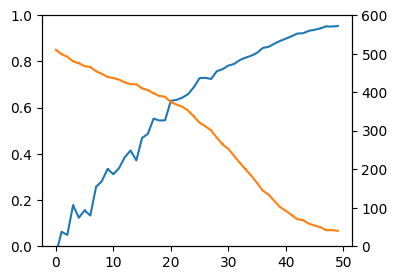

In [5]:
print_bool = False
epoch = -1
exp_num = 10
with open("C:\\Users\\hayas\\proj-regression-general\\git\\output\\ret\\20240603\\V\\exp0.pickle", 'rb') as p:
    return_dict = pickle.load(p)
evaluation.plot_learning_curve(features, return_dict, epoch_num, print_bool, "train")

In [6]:
pr_list, mse_list, p_pr_list, p_mse_list, t_pr_list, t_mse_list, r_pr_list, r_mse_list = [], [], [], [], [], [], [], []
for i in range(exp_num):
    file_name = "exp{}".format(i)
    with open("C:\\Users\\hayas\\proj-regression-general\\git\\output\\ret\\20240603\\V\\{}.pickle".format(file_name), 'rb') as p:
        return_dict = pickle.load(p)
    pr, mse = evaluation.cal_pearson_std(features, return_dict, epoch, print_bool, "test")
    pr_list.append(pr)
    mse_list.append(np.sqrt(mse))

print("{:.3f}: {:.3f}".format(np.mean(pr_list), np.mean(mse_list)))
print("{:.3f}: {:.3f}".format(np.std(pr_list), np.std(mse_list)))

0.303: 22.807
0.033: 0.535
